In [17]:
import pandas as pd
import sklearn
import tensorflow as tf
import numpy as np
from math import sqrt
from math import floor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

# lstm autoencoder predict sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout



# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [18]:
device_name = tf.test.gpu_device_name()
print(device_name)
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


/device:GPU:0
Found GPU at: /device:GPU:0


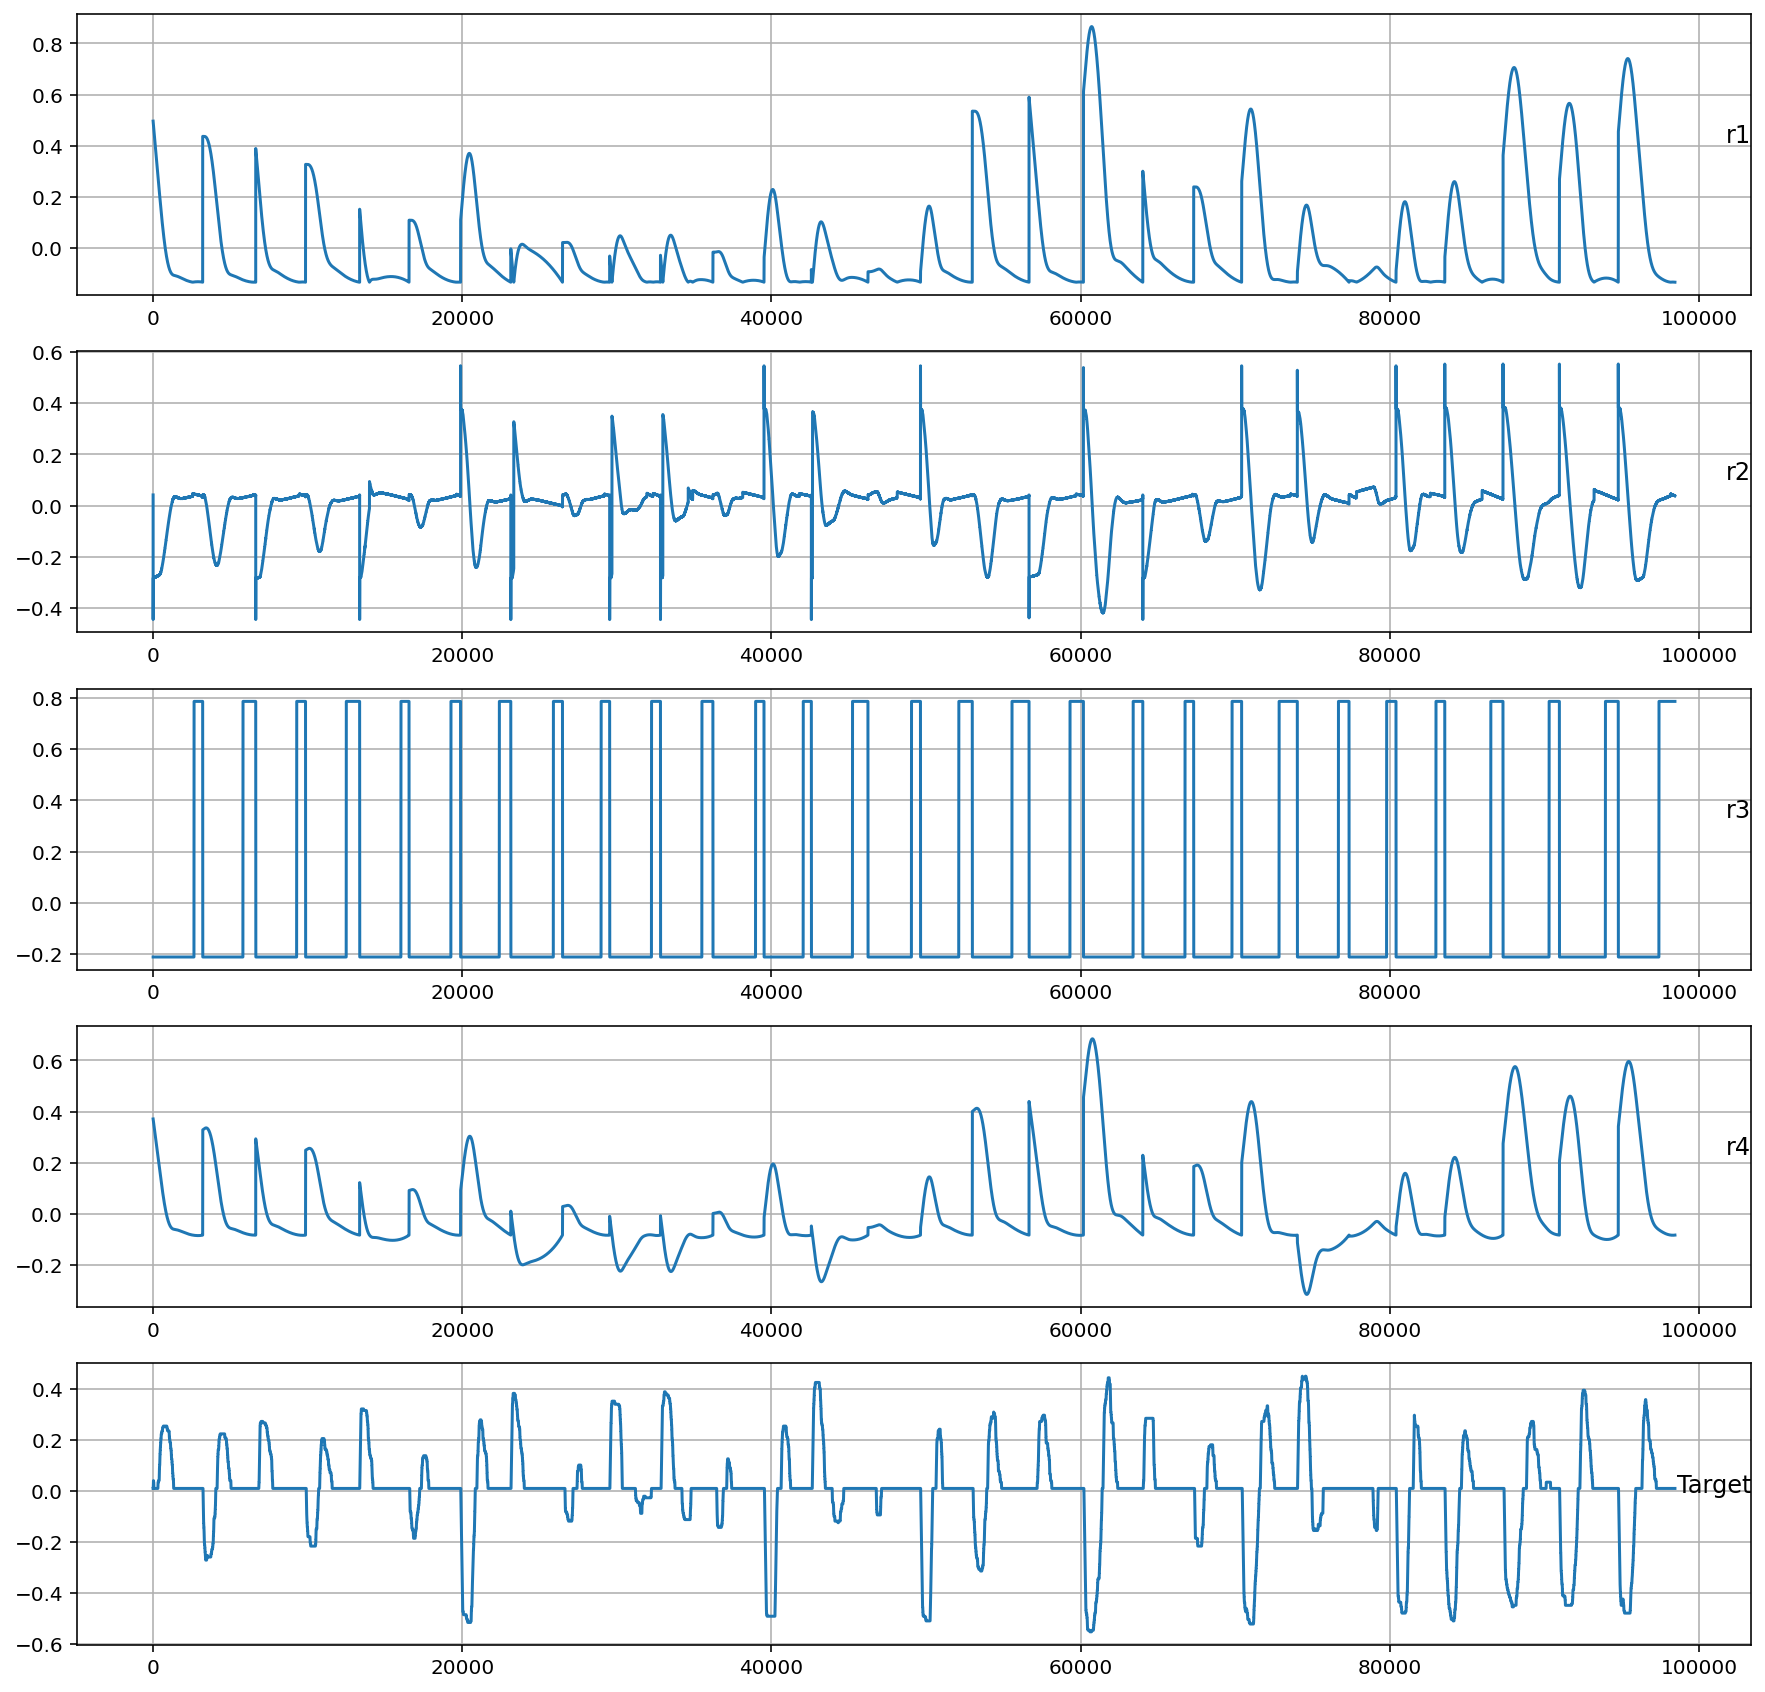

In [19]:
# Load training data set from CSV file
dataset = pd.read_csv("rally2_070720.csv", dtype=float)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5]
i = 1
# plot each column
fig1 = plt.figure(figsize=(15,15))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    plt.grid()
    i += 1

plt.show()

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
##Data preparation

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)
print('**********************************************************************************************')
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10]], axis=1, inplace=True)
print(reframed.head())

       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.630109   0.487762        0.0   0.686350   0.143452   0.560976   
2       0.629064   0.000293        0.0   0.685669   0.143452   0.560976   
3       0.628368   0.162691        0.0   0.685215   0.143452   0.560976   
4       0.627671   0.162683        0.0   0.684761   0.143452   0.560976   
5       0.626974   0.162681        0.0   0.684307   0.143452   0.560976   
...          ...        ...        ...        ...        ...        ...   
98441   0.000038   0.484015        1.0   0.232069   0.203076   0.560976   
98442   0.000030   0.484320        1.0   0.232077   0.203076   0.560976   
98443   0.000023   0.484315        1.0   0.232086   0.203076   0.560976   
98444   0.000015   0.484320        1.0   0.232095   0.203076   0.560976   
98445   0.000008   0.484315        1.0   0.232104   0.203076   0.560976   

        var1(t)   var2(t)  var3(t)   var4(t)   var5(t)   var6(t)  
1      0.629064  0.000293      0

(98446, 6)

In [22]:
# split into train and test sets
values = reframed.values
n_train_msec = floor(len(dataset)*0.8)
train = values[:n_train_msec, :]
test = values[n_train_msec:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(78756, 1, 6) (78756,) (19689, 1, 6) (19689,)


In [23]:
# # configure network
# n_batch = 1
# n_epoch = 1000
# n_neurons = 10
# # design network
# model = Sequential()
# model.add(LSTM(n_neurons, batch_input_shape=(n_batch,train_X.shape[1],train_X.shape[2]), stateful=True))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')


In [24]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(rate=0.2))


# model.add(LSTM(100, return_sequences=False))
# model.add(Dropout(rate=0.2))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=600, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
132/132 - 2s - loss: 0.0807 - val_loss: 0.0428
Epoch 2/50
132/132 - 0s - loss: 0.0202 - val_loss: 0.0257
Epoch 3/50
132/132 - 0s - loss: 0.0122 - val_loss: 0.0120
Epoch 4/50
132/132 - 0s - loss: 0.0069 - val_loss: 0.0042
Epoch 5/50
132/132 - 0s - loss: 0.0043 - val_loss: 0.0015
Epoch 6/50
132/132 - 0s - loss: 0.0033 - val_loss: 6.9008e-04
Epoch 7/50
132/132 - 0s - loss: 0.0028 - val_loss: 4.1634e-04
Epoch 8/50
132/132 - 0s - loss: 0.0025 - val_loss: 2.6640e-04
Epoch 9/50
132/132 - 0s - loss: 0.0023 - val_loss: 2.1667e-04
Epoch 10/50
132/132 - 0s - loss: 0.0022 - val_loss: 1.6762e-04
Epoch 11/50
132/132 - 0s - loss: 0.0021 - val_loss: 1.2439e-04
Epoch 12/50
132/132 - 0s - loss: 0.0020 - val_loss: 1.2264e-04
Epoch 13/50
132/132 - 0s - loss: 0.0019 - val_loss: 9.1989e-05
Epoch 14/50
132/132 - 0s - loss: 0.0018 - val_loss: 8.5315e-05
Epoch 15/50
132/132 - 0s - loss: 0.0017 - val_loss: 8.0067e-05
Epoch 16/50
132/132 - 0s - loss: 0.0017 - val_loss: 8.3146e-05
Epoch 17/50
132/132 -

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.011


In [29]:
yhat.shape

(19689, 1)

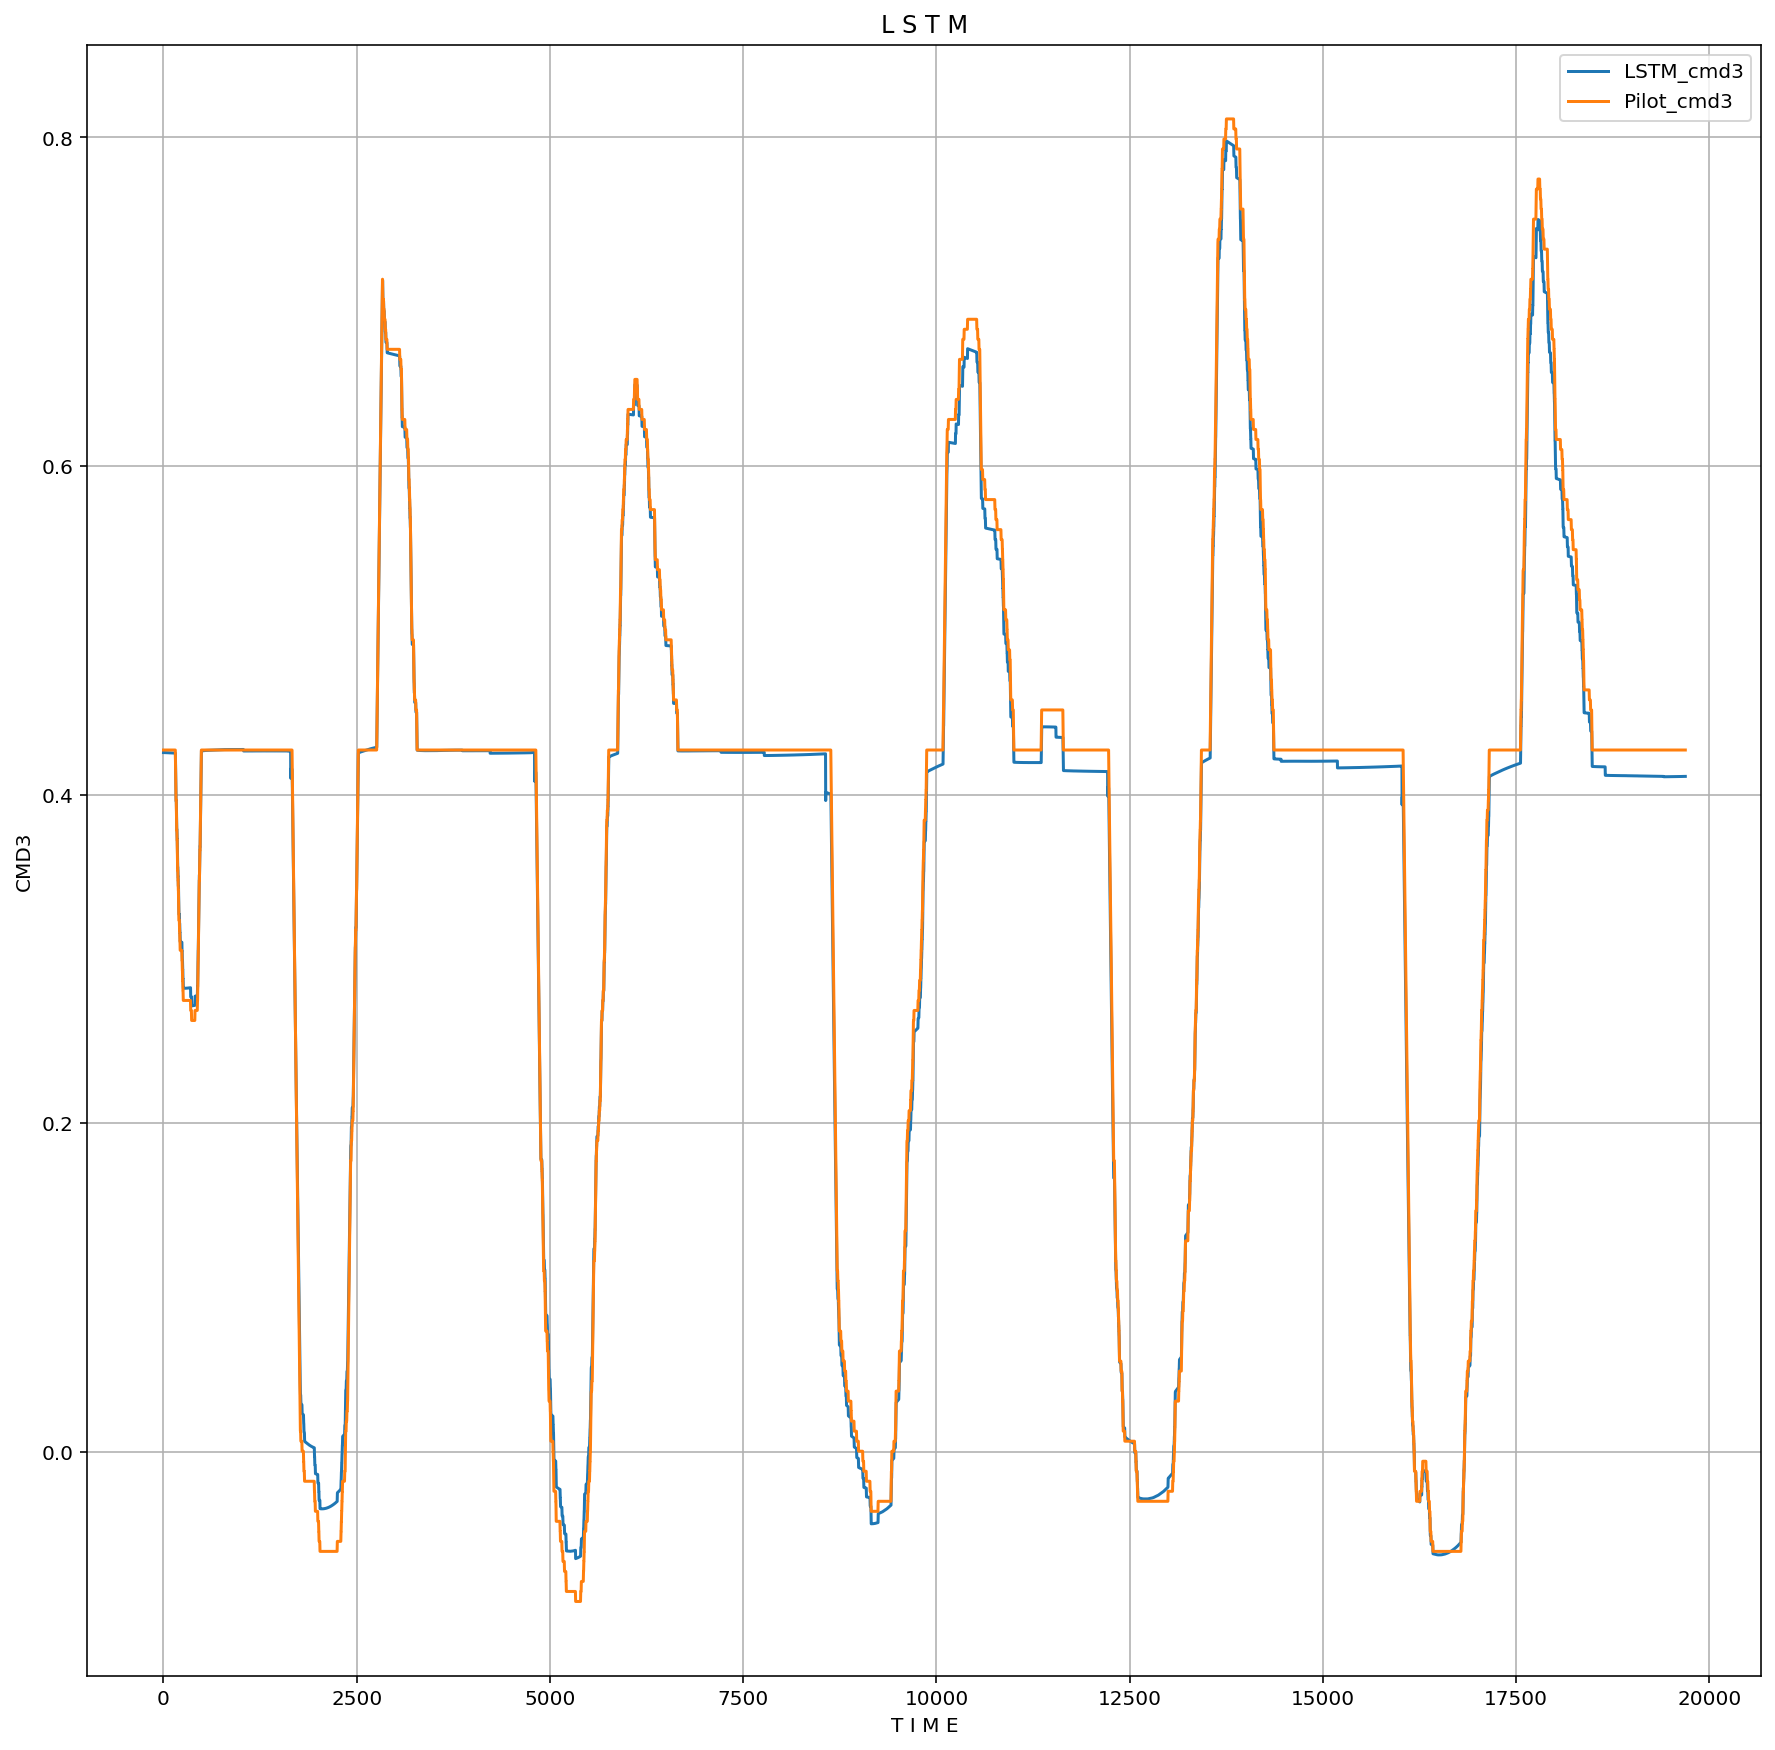

In [12]:
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
idx =list(range(0,len(inv_y)))
fig = plt.figure( figsize=(15, 15))
plt.plot(inv_yhat,label= 'LSTM_cmd3')
plt.plot(inv_y,label= 'Pilot_cmd3')

plt.legend()

plt.title('L S T M')
plt.xlabel('T I M E')
plt.ylabel('CMD3')

plt.grid()
plt.show()

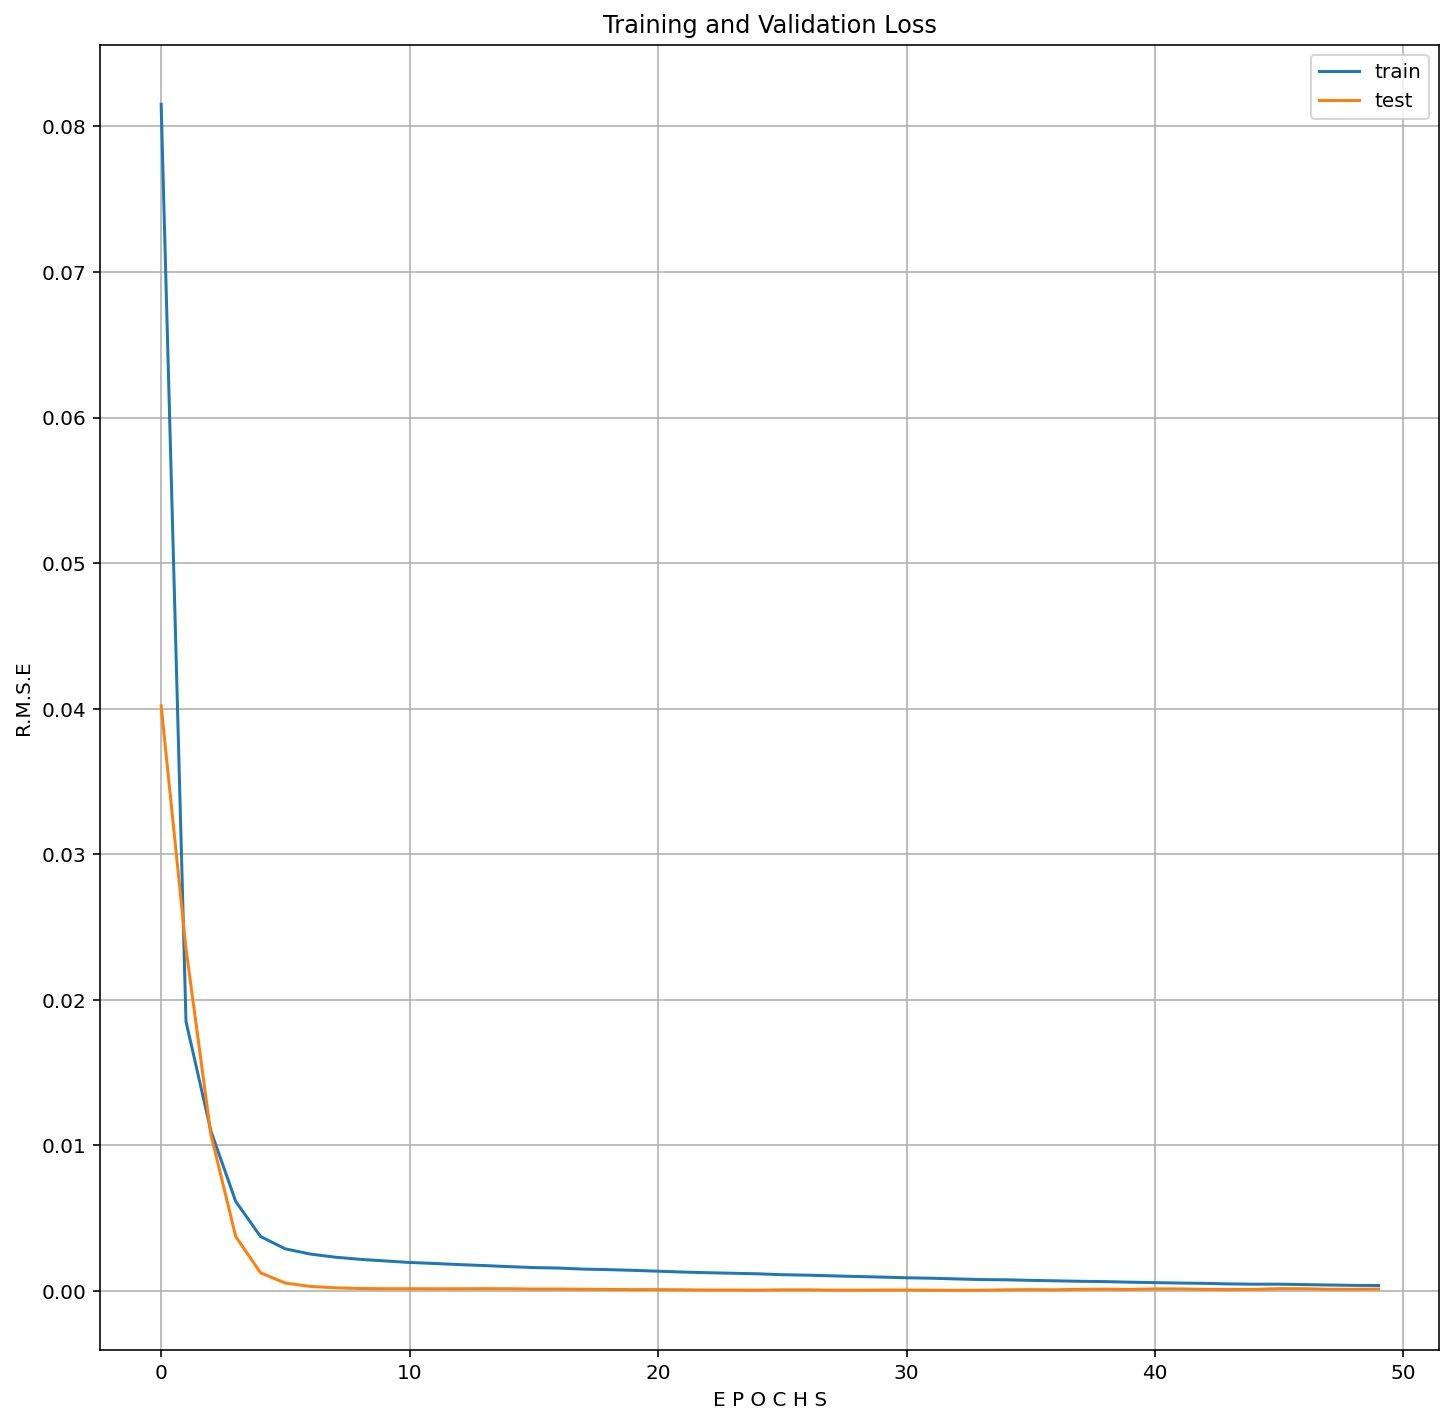

In [13]:
#plot history
fig = plt.figure(figsize=(12,12))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.title('Training and Validation Loss')
plt.xlabel('E P O C H S')
plt.ylabel('R.M.S.E')

plt.grid()
plt.show()

In [14]:
# def print_factors(x):
#    print("The factors of",x,"are:")
#    for i in range(1, x + 1):
#        if x % i == 0:
#            print(i)

# num = 78756

# print_factors(num)

In [15]:
# 6563

In [8]:
np.save('np_test',test_X)